# Import Tools

In [6]:
import pandas as pd

# Import DF

In [8]:
df_into_models = 'df_into_models.csv'

df = pd.read_csv(df_into_models)

# Check DF

In [10]:
df.shape

(73231, 20)

In [11]:
df.head()

,regio1,heatingType,newlyConst,balcony,pricetrend,noParkSpaces,hasKitchen,cellar,baseRent,livingSpace,condition,petsAllowed,lift,typeOfFlat,noRooms,floor,garden,buildingAge,firingTypes_grouped,Postal_Code
0,Bremen,self_contained_central_heating,False,True,2.46,0.0,False,False,765.00,84.97,good,negotiable,False,medium_quality,3.0,1.0,False,70.0,gas,9.803597
1,Schleswig Holstein,gas_heating,False,True,4.48,0.0,True,False,315.20,53.43,good,no,False,medium_quality,2.0,0.0,False,21.0,gas,6.171775
2,Sachsen,self_contained_central_heating,False,False,1.01,0.0,False,True,310.00,62.00,good,negotiable,False,unknown,2.0,1.0,True,55.0,other_unknown,5.773665
3,Bremen,central_heating,False,True,1.89,0.0,False,True,452.25,60.30,unknown,negotiable,False,medium_quality,3.0,2.0,False,61.0,electricity,8.059533
4,Baden Württemberg,oil_heating,False,False,3.77,1.0,True,True,580.00,53.00,good,no,False,high_quality,2.0,2.0,False,50.0,oil,9.611600


In [12]:
column_summary_df = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': df.dtypes.values,
    'Percentage Null': df.isnull().mean().values * 100,
    'Unique Values': df.nunique().values
})

print(column_summary_df)

            Column Name Data Type  Percentage Null  Unique Values
0                regio1    object              0.0             16
1           heatingType    object              0.0             14
2            newlyConst      bool              0.0              2
3               balcony      bool              0.0              2
4            pricetrend   float64              0.0           1029
5          noParkSpaces   float64              0.0              5
6            hasKitchen      bool              0.0              2
7                cellar      bool              0.0              2
8              baseRent   float64              0.0          10433
9           livingSpace   float64              0.0           8957
10            condition    object              0.0              6
11          petsAllowed    object              0.0              3
12                 lift      bool              0.0              2
13           typeOfFlat    object              0.0              4
14        

# Create Dummies (With and Without Dropping First Column)

In [14]:
# Dummies without dropping first column
df_dummies = pd.get_dummies(df)

# Dummies with dropping first column
df_dummies_drop = pd.get_dummies(df, drop_first=True)

# Define Features (X) and Target (y)

In [16]:
target = 'baseRent'  

X = df_dummies.drop(columns=[target])  # Without dropping a dummy
X_drop = df_dummies_drop.drop(columns=[target])  # Dropped dummy
y = df[target]

# Split into Train/Test Sets

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(X_drop, y, test_size=0.2, random_state=42)

# Normalize Where Required

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Identify numeric columns excluding boolean columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
bool_cols = X_train.select_dtypes(include=['bool', 'uint8']).columns

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Standard normalization (only numeric columns, no drop)
X_train_standard = X_train.copy()
X_test_standard = X_test.copy()

X_train_standard[numeric_cols] = standard_scaler.fit_transform(X_train[numeric_cols])
X_test_standard[numeric_cols] = standard_scaler.transform(X_test[numeric_cols])

# Standard normalization (only numeric columns, with drop)
X_train_drop_standard = X_train_drop.copy()
X_test_drop_standard = X_test_drop.copy()

X_train_drop_standard[numeric_cols] = standard_scaler.fit_transform(X_train_drop[numeric_cols])
X_test_drop_standard[numeric_cols] = standard_scaler.transform(X_test_drop[numeric_cols])

# MinMax normalization (all columns, including boolean/dummy, since it doesn’t distort booleans)
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

X_train_drop_minmax = minmax_scaler.fit_transform(X_train_drop)
X_test_drop_minmax = minmax_scaler.transform(X_test_drop)

In [44]:
X_train.shape

(58584, 64)

In [46]:
X_train_drop.shape

(58584, 58)

In [36]:
X_train_standard.shape

(58584, 64)

In [38]:
X_train_drop_standard.shape

(58584, 58)

In [40]:
X_train_minmax.shape

(58584, 64)

In [42]:
X_train_drop_minmax.shape

(58584, 58)

# Train Models Individually and Store Results

In [29]:
import time
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
import xgboost as xgb
import lightgbm as lgb

results = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    elapsed_time = time.time() - start_time

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2, "Time": elapsed_time}
    print(f"{name} \nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR² Score: {r2:.4f}\nTime: {elapsed_time:.2f} sec")

    with open(f"{name}.pkl", "wb") as file:
        pickle.dump(model, file)

# Run Each Model in Separate Cells

## KNN (MinMaxScaler and Standard, No Dummy Dropping)

In [22]:
knn_mm = KNeighborsRegressor(n_neighbors=5)
evaluate_model("KNN_MM", knn_mm, X_train_minmax, X_test_minmax, y_train, y_test)

KNN_MM 
MAE: 159.60
RMSE: 263.88
R² Score: 0.5257
Time: 3.44 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
knn_st = KNeighborsRegressor(n_neighbors=5)
evaluate_model("KNN_ST", knn_st, X_train_standard, X_test_standard, y_train, y_test)

KNN_ST 
MAE: 93.56
RMSE: 151.03
R² Score: 0.8446
Time: 3.23 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Linear Regression (MinMaxScaler and Standard, Dummy Dropping and No Dummy Dropping)

In [25]:
# No Dropping - MinMaxScaler
lr1 = LinearRegression()
evaluate_model("LinearRegression_ND_MM", lr1, X_train_minmax, X_test_minmax, y_train, y_test)

LinearRegression_ND_MM 
MAE: 92.94
RMSE: 140.41
R² Score: 0.8657
Time: 0.34 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
# No Dropping - Standard
lr2 = LinearRegression()
evaluate_model("LinearRegression_ND_St", lr2, X_train_standard, X_test_standard, y_train, y_test)

LinearRegression_ND_St 
MAE: 92.95
RMSE: 140.42
R² Score: 0.8657
Time: 0.38 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
# Dropping - MinMaxScaler
lr3 = LinearRegression()
evaluate_model("LinearRegression_Dr_MinMax", lr3, X_train_drop_minmax, X_test_drop_minmax, y_train, y_test)

LinearRegression_Dr_MinMax 
MAE: 92.95
RMSE: 140.42
R² Score: 0.8657
Time: 0.30 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [28]:
# Dropping - Standard
lr4 = LinearRegression()
evaluate_model("LinearRegression_Dr_St", lr4, X_train_drop_standard, X_test_drop_standard, y_train, y_test)

LinearRegression_Dr_St 
MAE: 92.95
RMSE: 140.42
R² Score: 0.8657
Time: 0.32 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Decision Tree (No Dummy Dropping - Scaling and No Scaling)

In [30]:
dt1 = DecisionTreeRegressor(max_depth=10)
evaluate_model("DecisionTree", dt1, X_train, X_test, y_train, y_test)

DecisionTree 
MAE: 80.44
RMSE: 137.40
R² Score: 0.8714
Time: 0.50 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
dt2 = DecisionTreeRegressor(max_depth=10)
evaluate_model("DecisionTree_MM", dt2, X_train_minmax, X_test_minmax, y_train, y_test)

DecisionTree_MM 
MAE: 80.31
RMSE: 136.15
R² Score: 0.8738
Time: 0.48 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [32]:
dt3 = DecisionTreeRegressor(max_depth=10)
evaluate_model("DecisionTree_St", dt3, X_train_standard, X_test_standard, y_train, y_test)

DecisionTree_St 
MAE: 80.66
RMSE: 140.89
R² Score: 0.8648
Time: 0.68 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Random Forest (No Dummy Dropping - Scaling and No Scaling)

In [34]:
rf1 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
evaluate_model("RandomForest", rf1, X_train, X_test, y_train, y_test)

RandomForest 
MAE: 73.49
RMSE: 119.65
R² Score: 0.9025
Time: 37.25 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
rf2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
evaluate_model("RandomForest_MM", rf2, X_train_minmax, X_test_minmax, y_train, y_test)

RandomForest_MM 
MAE: 73.49
RMSE: 119.64
R² Score: 0.9025
Time: 34.60 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [36]:
rf3 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
evaluate_model("RandomForest_St", rf3, X_train_standard, X_test_standard, y_train, y_test)

RandomForest_St 
MAE: 73.49
RMSE: 119.59
R² Score: 0.9026
Time: 33.58 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Gradient Boosting (No Dummy Dropping - Scaling and No Scaling)

In [38]:
gb1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
evaluate_model("GradientBoosting", gb1, X_train, X_test, y_train, y_test)

GradientBoosting 
MAE: 68.17
RMSE: 114.54
R² Score: 0.9106
Time: 47.64 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
gb2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
evaluate_model("GradientBoosting_MM", gb2, X_train_minmax, X_test_minmax, y_train, y_test)

GradientBoosting_MM 
MAE: 68.16
RMSE: 114.52
R² Score: 0.9107
Time: 47.42 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
gb3 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
evaluate_model("GradientBoosting_St", gb2, X_train_standard, X_test_standard, y_train, y_test)

GradientBoosting_St 
MAE: 68.16
RMSE: 114.88
R² Score: 0.9101
Time: 44.76 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Bagging Regressor (No Dummy Dropping - Scaling and No Scaling)

In [42]:
bagging1 = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10), n_estimators=100, random_state=42)
evaluate_model("BaggingRegressor", bagging1, X_train, X_test, y_train, y_test)

BaggingRegressor 
MAE: 73.52
RMSE: 119.73
R² Score: 0.9024
Time: 36.35 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [43]:
bagging2 = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10), n_estimators=100, random_state=42)
evaluate_model("BaggingRegressor_MM", bagging2, X_train_minmax, X_test_minmax, y_train, y_test)

BaggingRegressor_MM 
MAE: 73.53
RMSE: 119.73
R² Score: 0.9024
Time: 33.98 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [44]:
bagging3 = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10), n_estimators=100, random_state=42)
evaluate_model("BaggingRegressor_St", bagging3, X_train_standard, X_test_standard, y_train, y_test)

BaggingRegressor_St 
MAE: 73.51
RMSE: 119.63
R² Score: 0.9025
Time: 35.05 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## AdaBoost Regressor (No Dummy Dropping - Scaling and No Scaling)

In [46]:
ada1 = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10), n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model("AdaBoostRegressor", ada1, X_train, X_test, y_train, y_test)

AdaBoostRegressor 
MAE: 73.82
RMSE: 120.06
R² Score: 0.9018
Time: 59.44 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [47]:
ada2 = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10), n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model("AdaBoostRegressor", ada2, X_train_minmax, X_test_minmax, y_train, y_test)

AdaBoostRegressor 
MAE: 73.77
RMSE: 119.10
R² Score: 0.9034
Time: 56.78 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [48]:
ada3 = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10), n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model("AdaBoostRegressor", ada3, X_train_standard, X_test_standard, y_train, y_test)

AdaBoostRegressor 
MAE: 73.79
RMSE: 119.38
R² Score: 0.9029
Time: 63.89 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## XGBoost (No Dummy Dropping - Scaling and No Scaling)

In [50]:
xgboost = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
evaluate_model("XGBoost", xgboost, X_train, X_test, y_train, y_test)

XGBoost 
MAE: 68.18
RMSE: 115.41
R² Score: 0.9093
Time: 3.02 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [51]:
xgboost = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
evaluate_model("XGBoost_MM", xgboost, X_train_minmax, X_test_minmax, y_train, y_test)

XGBoost_MM 
MAE: 68.18
RMSE: 115.41
R² Score: 0.9093
Time: 2.48 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [52]:
xgboost = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
evaluate_model("XGBoost_St", xgboost, X_train_standard, X_test_standard, y_train, y_test)

XGBoost_St 
MAE: 68.18
RMSE: 115.41
R² Score: 0.9093
Time: 3.44 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## LightGBM (No Dummy Dropping - Scaling and No Scaling)

In [54]:
lgbm1 = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model("LightGBM", lgbm1, X_train, X_test, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 58584, number of used features: 63
[LightGBM] [Info] Start training from score 600.815422
LightGBM 
MAE: 69.97
RMSE: 113.53
R² Score: 0.9122
Time: 0.55 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [55]:
lgbm2 = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model("LightGBM_MM", lgbm2, X_train_minmax, X_test_minmax, y_train, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 58584, number of used features: 63
[LightGBM] [Info] Start training from score 600.815422
LightGBM_MM 
MAE: 69.99
RMSE: 113.83
R² Score: 0.9117
Time: 0.62 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [56]:
lgbm3 = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model("LightGBM_St", lgbm3, X_train_standard, X_test_standard, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the train set: 58584, number of used features: 63
[LightGBM] [Info] Start training from score 600.815422
LightGBM_St 
MAE: 69.81
RMSE: 113.12
R² Score: 0.9129
Time: 0.61 sec


C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Compare Results in a Table

In [58]:
results_df = pd.DataFrame(results).T
results_df.sort_values(by="R2", ascending=False)

,MAE,RMSE,R2,Time
LightGBM_St,69.814819,113.116239,0.912853,0.609259
LightGBM,69.967383,113.531887,0.912212,0.546262
LightGBM_MM,69.990007,113.831215,0.911748,0.622253
GradientBoosting_MM,68.163190,114.516823,0.910682,47.422780
GradientBoosting,68.170961,114.542055,0.910643,47.636270
GradientBoosting_St,68.156079,114.879649,0.910115,44.756332
XGBoost,68.179032,115.408855,0.909285,3.020665
XGBoost_St,68.179032,115.408855,0.909285,3.435692
XGBoost_MM,68.179032,115.408855,0.909285,2.478265
AdaBoostRegressor,73.794132,119.384919,0.902927,63.891348


# Hyperparameter

In [107]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'num_leaves': [20, 31, 50]
}

lgbm = LGBMRegressor(n_jobs=-1)

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',  # MAE as the metric
    n_jobs=-1,
    verbose=1
)

start_time = time.time()

grid_search.fit(X_train_standard, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Negative because scikit-learn minimizes

print(f"Total Training Time: {elapsed_time:.2f} seconds")
print(f"Best Parameters: {best_params}")
print(f"Best MAE (Cross-Validation): {best_score:.2f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the train set: 58584, number of used features: 63
[LightGBM] [Info] Start training from score 600.815422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## LightGBM - Best Parameters

In [31]:
lgbm4 = lgb.LGBMRegressor(n_estimators=500, max_depth = 10, learning_rate=0.1, num_leaves = 50, random_state=42)
evaluate_model("LightGBM_St_Best_Par", lgbm4, X_train_standard, X_test_standard, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the train set: 58584, number of used features: 63
[LightGBM] [Info] Start training from score 600.815422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\barba\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\barba\AppData\Local\Temp\ipykernel_9308\1424562816.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


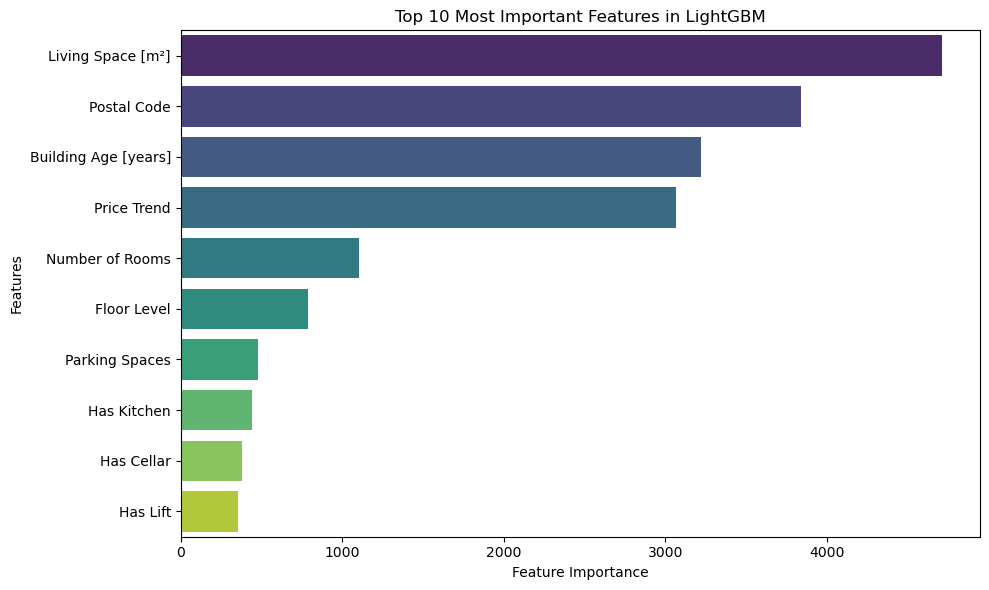

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = lgbm4.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train_standard.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_names = {
    'livingSpace': 'Living Space [m²]',
    'Postal_Code': 'Postal Code',
    'buildingAge': 'Building Age [years]',
    'pricetrend': 'Price Trend',
    'noRooms': 'Number of Rooms',
    'floor': 'Floor Level',
    'noParkSpaces': 'Parking Spaces',
    'hasKitchen': 'Has Kitchen',
    'cellar': 'Has Cellar',
    'lift': 'Has Lift'
}

features_df['Feature'] = features_df['Feature'].replace(feature_names)

top_features = features_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Most Important Features in LightGBM')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
